  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB
None
       buying  maint doors persons lug_boot safety  class
count    1728   1728  1728    1728     1728   1728   1728
unique      4      4     4       3        3      3      4
top     vhigh 

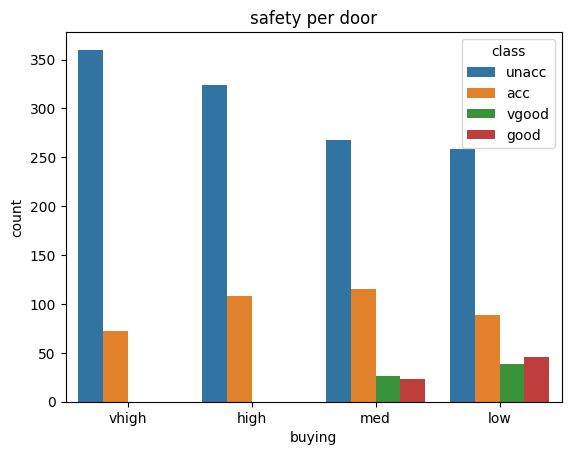

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import zscore

# Load the dataset
try:
    df = pd.read_csv('car.data', header=None, names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])
except FileNotFoundError:
    print("Error: 'car.data' not found. Please upload the dataset file.")
    exit()

print(df.head())
print(df.info())
print(df.describe())
print(df['safety'].value_counts())

# Check MissingValues
print((df.isnull().sum() / len(df)) * 100)

sns.countplot(data=df, x='buying', hue='class')
plt.title("safety per door")
plt.show()


In [5]:
# Outlier Detection
numeric_data = df.drop(['buying', 'class'], axis=1)

# Convert columns to numeric if they are not already
for col in numeric_data.columns:
    numeric_data[col] = pd.to_numeric(numeric_data[col], errors='coerce')

# Compute Z-scores
z_scores = np.abs(zscore(numeric_data))

# Set threshold
threshold = 3
outliers = (z_scores > threshold).any(axis=1)

# Filter out outliers
df_cleaned = df[~outliers].reset_index(drop=True)

print(f"\nOriginal dataset size: {df.shape[0]}")
print(f"Cleaned dataset size (after outlier removal): {df_cleaned.shape[0]}")


Original dataset size: 1728
Cleaned dataset size (after outlier removal): 1728


In [6]:
# Preprocessing Data
le = LabelEncoder()
for col in df_cleaned.columns:
    df_cleaned[col] = le.fit_transform(df_cleaned[col])

# Separate features (X) and target (y)
X = df_cleaned.drop('class', axis=1)
y = df_cleaned['class']

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize feature data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial Features
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



In [11]:
# Model training and Evaluation (baseline model)
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': CategoricalNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
}

# Baseline: Scaled only
print("Baseline: Standard Scaled Features")
for name, model in models.items():
    if name == 'Naive Bayes':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

# With Polynomial Features
print("With Polynomial Features")
for name, model in models.items():
    if name == 'Naive Bayes':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_poly, y_train)
        y_pred = model.predict(X_test_poly)
    print(f"\n{name} with Polynomial Features Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

Baseline: Standard Scaled Features

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        83
           1       1.00      0.64      0.78        11
           2       0.97      1.00      0.98       235
           3       0.92      0.65      0.76        17

    accuracy                           0.94       346
   macro avg       0.94      0.79      0.85       346
weighted avg       0.94      0.94      0.94       346


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.54      0.58        83
           1       0.57      0.36      0.44        11
           2       0.87      0.97      0.91       235
           3       1.00      0.35      0.52        17

    accuracy                           0.82       346
   macro avg       0.77      0.56      0.62       346
weighted avg       0.81      0.82      0.80       346


Decision Tree 


K-Nearest Neighbors Best Hyperparameters: {'n_neighbors': 3}
K-Nearest Neighbors Best Score: 0.9153037199811646

K-Nearest Neighbors Classification Report (after tuning):
              precision    recall  f1-score   support

           0       0.84      0.92      0.87        83
           1       0.70      0.64      0.67        11
           2       0.99      0.96      0.98       235
           3       0.88      0.88      0.88        17

    accuracy                           0.94       346
   macro avg       0.85      0.85      0.85       346
weighted avg       0.94      0.94      0.94       346



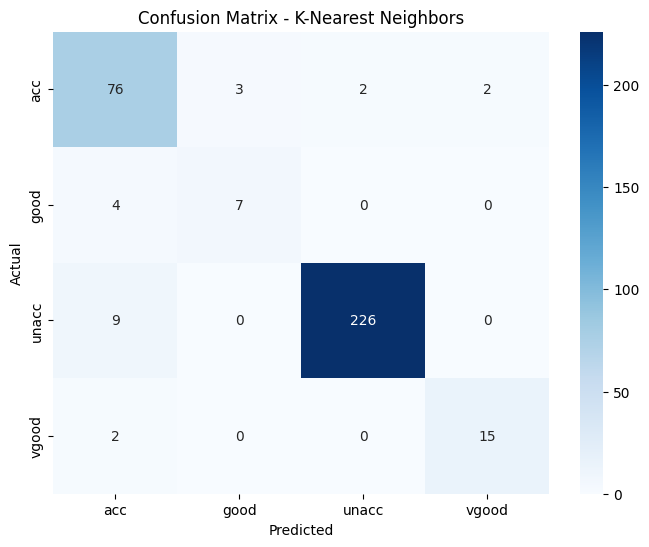


Naive Bayes Best Hyperparameters: {}
Naive Bayes Best Score: 0.8400826662481033

Naive Bayes Classification Report (after tuning):
              precision    recall  f1-score   support

           0       0.63      0.54      0.58        83
           1       0.57      0.36      0.44        11
           2       0.87      0.97      0.91       235
           3       1.00      0.35      0.52        17

    accuracy                           0.82       346
   macro avg       0.77      0.56      0.62       346
weighted avg       0.81      0.82      0.80       346



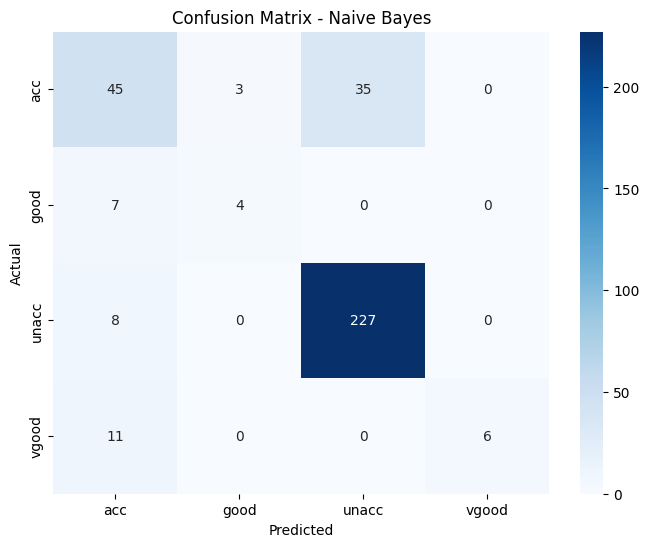


Decision Tree Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2}
Decision Tree Best Score: 0.9768456024695233

Decision Tree Classification Report (after tuning):
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        83
           1       0.62      0.91      0.74        11
           2       1.00      1.00      1.00       235
           3       1.00      0.94      0.97        17

    accuracy                           0.97       346
   macro avg       0.90      0.94      0.91       346
weighted avg       0.98      0.97      0.98       346



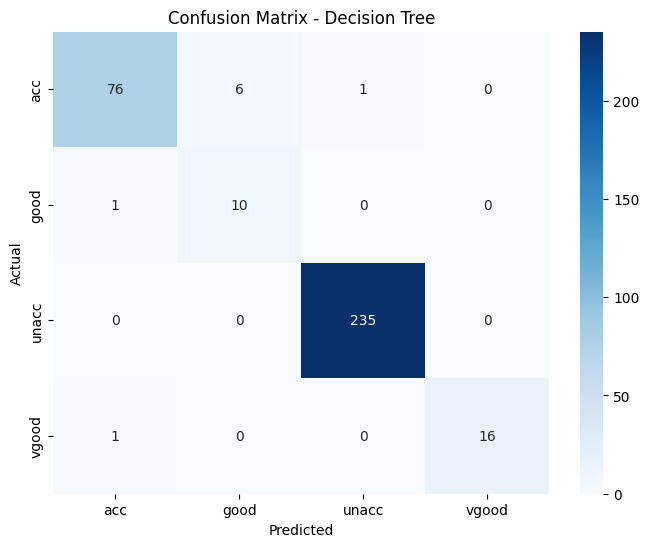

In [14]:
# Hyperparameter Tuning using GridSearchCV
param_grids = {
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 9]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'Naive Bayes': {} # No hyperparameters to tune for CategoricalNB
}

for name, model in models.items():
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy')

        if name == 'Naive Bayes':
            grid_search.fit(X_train, y_train)
            y_pred = grid_search.predict(X_test)
        else:
            grid_search.fit(X_train_scaled, y_train)
            y_pred = grid_search.predict(X_test_scaled)

        print(f"\n{name} Best Hyperparameters: {grid_search.best_params_}")
        print(f"{name} Best Score: {grid_search.best_score_}")
        print(f"\n{name} Classification Report (after tuning):")
        print(classification_report(y_test, y_pred, zero_division=0))
        plot_confusion_matrix(y_test, y_pred, name)
    else:
        print(f"No hyperparameter tuning for {name}")
